In [1]:
import os
import pandas as pd
import geopandas as gpd
import shapely
import numpy as np
import torch
import random
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from plotly import express as px

import mysql.connector as mysql
username = os.environ['MYSQL_user']
password = os.environ['MYSQL_password']
DB = mysql.connect(host = "localhost", user = username, passwd = password, database = "AIRBNB")
cursor = DB.cursor(buffered=True)

In [2]:
class Plots:
    def check_data(self, data):
        if not isinstance(data, pd.DataFrame) and not isinstance(data, pd.Series) and not isinstance(data, np.ndarray) and not torch.is_tensor(data):
            raise TypeError('Wrong type of data. It should be pandas DataFrame, pandas Series, numpy array or torch tensor.')
        data = np.array(data)
        if(data.ndim == 2):
            data = data.squeeze()
        return data
    
    def check_2d_data(self, data):
        if not isinstance(data, pd.DataFrame) and not isinstance(data, pd.Series) and not isinstance(data, np.ndarray) and not torch.is_tensor(data):
            raise TypeError('Wrong type of data. It should be pandas DataFrame, pandas Series, numpy array or torch tensor.')
        return np.array(data)
    
    def monthly_listings(self, data):
        unique_id_counts = data['id'].value_counts(ascending=True)
        counts = unique_id_counts.value_counts().to_dict()
        sorted_counts = dict(sorted(counts.items(), key=lambda item: item[0]))
        labels = list(sorted_counts.keys())
        frequency = list(sorted_counts.values())
        n_colors = len(counts)
        colors = px.colors.sample_colorscale("portland", [n/(n_colors -1) for n in range(n_colors)])
        fig = go.Figure()
        fig.add_trace(go.Bar(x=labels, y=frequency, marker=dict(line=dict(color='black', width=1), color=colors), showlegend=False))
        fig.update_layout(template="simple_white", width=1600, height=800, title=f"<b>Number of months a listing is active<b>", title_x=0.5, xaxis_title="Number of months", yaxis_title="Number of unique listings", font=dict(family="Times New Roman",size=16,color="Black"))
        fig.update_xaxes(tickvals=labels)
        fig.show("png")
    
    def histogram_and_box_plot(self, data, name="", with_annotation=True, bin_size=1):
        data = self.check_data(data=data)
        fig = make_subplots(rows=1, cols=2, specs=[[{"type": "histogram"}, {"type": "box"}]])
        fig.add_trace(go.Box(y=data, name='', marker=dict(color="rgb(48,70,116)"), showlegend=False), row=1, col=1)
        fig.add_trace(go.Histogram(x=data, marker=dict(color="rgb(48,70,116)"), showlegend=False, xbins=dict(size=bin_size)), row=1, col=2)
        if(with_annotation==True):
            for x in zip(["Min","Q1","Med","Q3","Max"], np.quantile(data, [0, 0.25, 0.5, 0.75, 1])):
                fig.add_annotation(x=0.4, y=x[1], text=x[0] + ": " + str(np.round(x[1], 3)), showarrow=False)
        fig.update_layout(template="simple_white", width=1600, height=800, title=f"<b>{name.title()} distribution<b>", title_x=0.5, font=dict(family="Times New Roman",size=16,color="Black"))
        fig.show("png")
    
    def pie_boxplot(self, data, name=""):
        data = self.check_data(data=data)
        data = list(data)
        rows = 1
        columns = 2
        labels, frequency = np.unique(data, return_counts=True)
        sorted_indices = np.argsort(frequency)[::-1]
        labels = labels[sorted_indices]
        frequency = frequency[sorted_indices]
        colors = px.colors.qualitative.Dark24
        fig = make_subplots(rows=rows, cols=columns, specs=[[{"type": "pie"}, {"type": "bar"}] for i in range(0, rows)])
        fig.add_trace(go.Pie(values=frequency, labels=labels, showlegend=True, textinfo='value+percent', hole=0.3, marker=dict(line=dict(color='black', width=2), colors=colors)), row=1, col=1)
        fig.add_trace(go.Bar(x=labels, y=frequency, marker=dict(line=dict(color='black', width=1), color=colors), showlegend=False), row=1, col=2)
        fig.update_layout(template="simple_white", width=1600, height=800, title=f"<b>Pie chart and bar chart {name.title()}<b>", title_x=0.5, font=dict(family="Times New Roman",size=16,color="Black"))
        fig.show("png")

    def boxplot_by_categorical(self, data, categorical, target, name=""):
        data_copy = data.copy()
        data_copy.reset_index(drop=True, inplace=True)
        labels, frequency = np.array(data_copy[categorical].value_counts().index), np.array(data_copy[categorical].value_counts().values)
        sorted_indices = np.argsort(frequency)[::-1]
        labels = labels[sorted_indices]
        frequency = frequency[sorted_indices]
        colors = px.colors.qualitative.Dark24
        rows, columns = 1, 2
        fig = make_subplots(rows=rows, cols=columns, specs=[[{"type": "pie"}, {"type": "bar"}] for i in range(0, rows)])
        fig.add_trace(go.Pie(values=frequency, labels=labels, showlegend=True, textinfo='value+percent', hole=0.3, marker=dict(line=dict(color='black', width=2), colors=colors)), row=1, col=1)
        for color_idx, category in enumerate(labels):
            indices = list(np.where(data_copy[categorical]==category)[0])
            grouped_data = list(data_copy[target][indices])
            try:
                fig.add_trace(go.Box(y=grouped_data, name=str(category), marker=dict(color=colors[color_idx]), showlegend=False))
            except:
                fig.add_trace(go.Box(y=grouped_data, name=str(category), marker=dict(color=colors[random.randint(0, len(colors)-1)]), showlegend=False))
        fig.update_layout(template="simple_white", width=1600, height=800, title=f"<b>{name.title()} distribution<b>", title_x=0.5, font=dict(family="Times New Roman",size=16,color="Black"))
        fig.show("png")
    
    def barplot_missing_values(self, data, features_names, name=""):
        data = self.check_data(data=data)
        fig = go.Figure()
        fig.add_trace(go.Bar(x=features_names, y=data, marker=dict(color=data, colorscale='viridis', line=dict(color='black', width=1))))
        fig.update_layout(template="simple_white", width=max(30*len(features_names), 600), height=max(30*len(features_names), 600), title=f"<b>Bar chart {name.title()}<b>", title_x=0.5, yaxis_title="Frequency", xaxis=dict(title="Features", showticklabels=True), font=dict(family="Times New Roman", size=16 ,color="Black"))
        fig.show("png")
    
plots = Plots()

## Merge dataframes

In [5]:
listings_oct_2023 = pd.read_csv('listings_oct_2023.csv')
listings_nov_2023 = pd.read_csv('listings_nov_2023.csv')
listings_dec_2023 = pd.read_csv('listings_dec_2023.csv')
listings_jan_2024 = pd.read_csv('listings_jan_2024.csv')
listings_feb_2024 = pd.read_csv('listings_feb_2024.csv')
listings_mar_2024 = pd.read_csv('listings_mar_2024.csv')
listings_apr_2024 = pd.read_csv('listings_apr_2024.csv')
listings_may_2024 = pd.read_csv('listings_may_2024.csv')
listings_jun_2024 = pd.read_csv('listings_jun_2024.csv')
listings_jul_2024 = pd.read_csv('listings_jul_2024.csv')
listings_aug_2024 = pd.read_csv('listings_aug_2024.csv')
listings_sep_2024 = pd.read_csv('listings_sep_2024.csv')
listings_oct_2024 = pd.read_csv('listings_oct_2024.csv')
listings_nov_2024 = pd.read_csv('listings_nov_2024.csv')
monthly_dataframes = [
    listings_oct_2023, listings_nov_2023, listings_dec_2023,
    listings_jan_2024, listings_feb_2024, listings_mar_2024,
    listings_apr_2024, listings_may_2024, listings_jun_2024,
    listings_jul_2024, listings_aug_2024, listings_sep_2024,
    listings_oct_2024, listings_nov_2024
]
all_listings = pd.concat(monthly_dataframes, ignore_index=True)
print(f"Number of rows: {all_listings.shape[0]}")
all_listings.head()

Number of rows: 463836


,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,9630344,https://www.airbnb.com/rooms/9630344,20231001204715,2023-10-02,city scrape,Rental unit in Brooklyn · ★4.80 · 1 bedroom ·...,Enjoy your own private bedroom in our 2 bedroo...,Easy access to subway. Trendy and yet quiet.,https://a0.muscache.com/pictures/496cf3f1-7d0d...,47783628,...,5.00,4.80,5.00,NaN,f,1,0,1,0,0.06
1,3533741,https://www.airbnb.com/rooms/3533741,20231001204715,2023-10-02,previous scrape,Rental unit in New York · 1 bedroom · 1 bed · ...,Come stay in the heart of historic Hells Kitch...,NaN,https://a0.muscache.com/pictures/45157664/862a...,17791294,...,NaN,NaN,NaN,NaN,f,1,0,1,0,NaN
2,9731039,https://www.airbnb.com/rooms/9731039,20231001204715,2023-10-02,previous scrape,Rental unit in Queens · Studio · 1 bed · 1 bath,Studio Apartment in the heart of Sunnyside: of...,NaN,https://a0.muscache.com/pictures/81a96b92-d357...,50213378,...,NaN,NaN,NaN,NaN,f,1,1,0,0,NaN
3,21736164,https://www.airbnb.com/rooms/21736164,20231001204715,2023-10-02,previous scrape,Rental unit in Brooklyn · 1 bedroom · 1 bed · ...,"Light-filled, high-ceilinged 1BR brownstone ap...","The neighborhood is vibrant, multicultural, an...",https://a0.muscache.com/pictures/4e3ee5e2-baa1...,4298654,...,5.00,5.00,5.00,NaN,f,1,1,0,0,0.03
4,22280002,https://www.airbnb.com/rooms/22280002,20231001204715,2023-10-01,city scrape,Rental unit in Brooklyn · ★4.98 · 1 bedroom · ...,This is a comfortable super spacious sunny 1 b...,Welcome to the enchanting neighborhood of Stuy...,https://a0.muscache.com/pictures/b187bce7-ded7...,67373899,...,4.91,4.94,4.92,NaN,f,1,1,0,0,1.26


In [5]:
all_listings.sort_values(by=['id', 'last_scraped'], ascending=[True, False], inplace=True)
unique_listings = all_listings.drop_duplicates(subset='id', keep='first')
unique_listings.reset_index(drop=True, inplace=True)
df = unique_listings.sort_values(by='last_scraped', ascending=True)
df.head()

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
40397,926921149554077884,https://www.airbnb.com/rooms/926921149554077884,20231001204715,2023-10-01,city scrape,Rental unit in New York · 1 bedroom · 3 beds ·...,An entire apt! Beautiful and super Cute 1Bed ...,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,92735223,...,NaN,NaN,NaN,NaN,f,2,2,0,0,NaN
36353,829285374704926621,https://www.airbnb.com/rooms/829285374704926621,20231001204715,2023-10-01,city scrape,Rental unit in Brooklyn · ★4.33 · 1 bedroom · ...,QUEEN SIZED bed; PERFECT for COUPLES! VERY ACC...,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,171136827,...,4.56,4.33,4.11,NaN,t,3,0,3,0,2.40
36620,835684423867986488,https://www.airbnb.com/rooms/835684423867986488,20231001204715,2023-10-01,city scrape,Home in Brooklyn · ★4.79 · 3 bedrooms · 5 beds...,This house is truly a delightful space. From t...,NaN,https://a0.muscache.com/pictures/329ef3cc-d57f...,185784030,...,4.79,4.37,4.63,NaN,t,2,2,0,0,2.77
42516,981180510375846612,https://www.airbnb.com/rooms/981180510375846612,20231001204715,2023-10-01,city scrape,Rental unit in New York · ★New · 3 bedrooms · ...,This historic property nestled in the heart of...,NaN,https://a0.muscache.com/pictures/prohost-api/H...,451776967,...,NaN,NaN,NaN,Exempt,f,1,1,0,0,NaN
36947,842129882303677227,https://www.airbnb.com/rooms/842129882303677227,20231001204715,2023-10-01,city scrape,Rental unit in New York · ★4.90 · 1 bedroom · ...,Private room in luxury riverside apartment for...,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,124088338,...,4.97,4.76,4.76,NaN,f,1,0,1,0,4.55


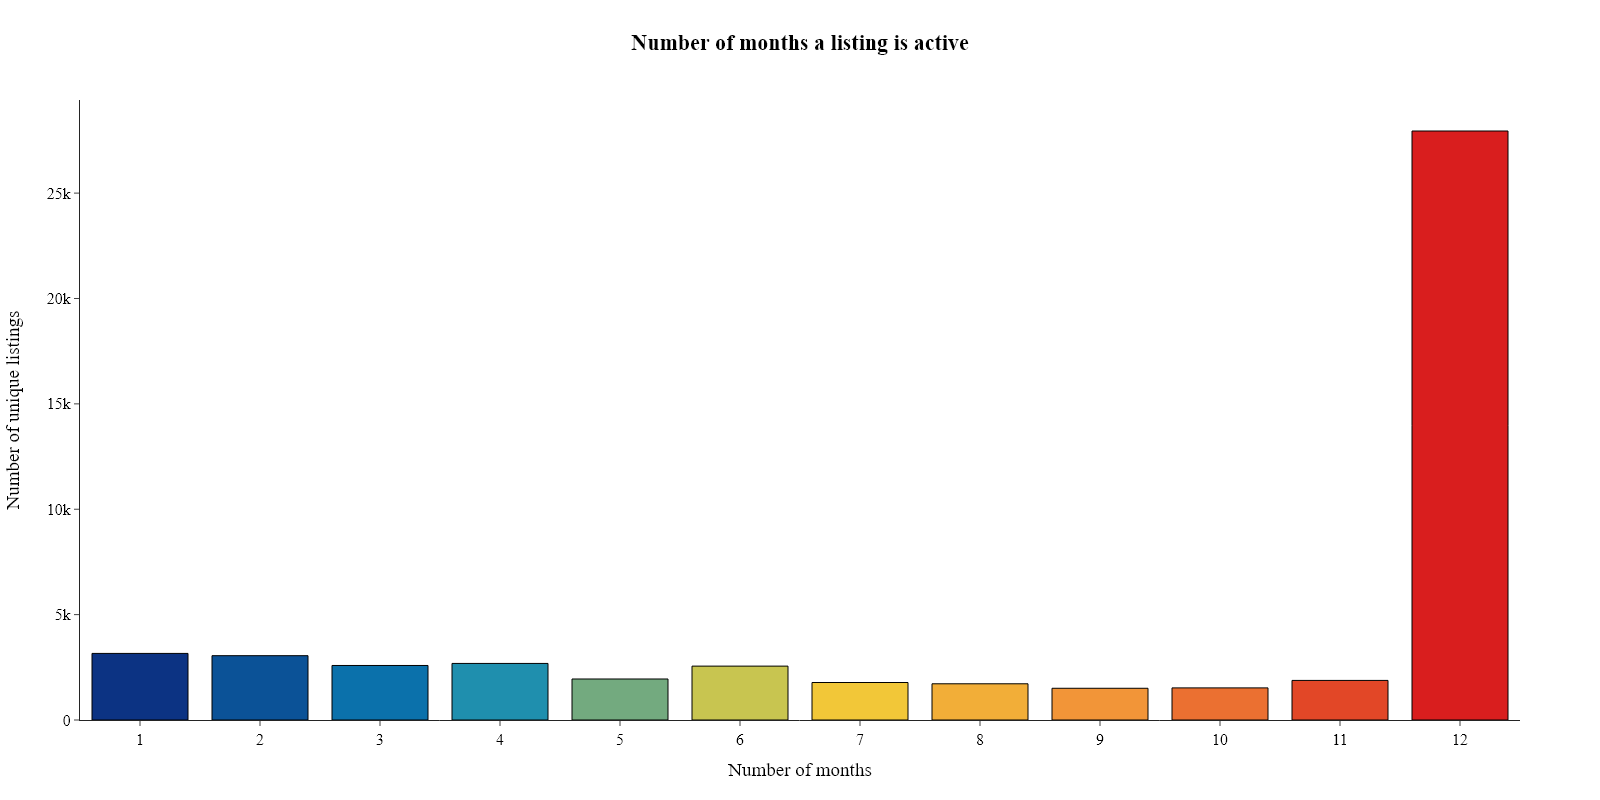

In [6]:
plots.monthly_listings(data=all_listings)

**Notes:**
- Most of listings were active for the whole year.
- The distribution for other months than 12 is almost the same.

## Removal of unnecessary columns

unnecessary_columns = ['source', 'scrape_id', 'name', 'description', 'neighborhood_overview', 'picture_url', 'host_url', 'host_name', 'host_location', 'host_about', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'neighbourhood', 'neighbourhood_cleansed', 'calendar_updated', 'calendar_last_scraped', 'license', 'has_availability']
Following columns are removed (all not needed for analysis):
- `source` - Source of scraping: "city scrape" or "previous scrape".
- `scrape_id` - Inside Airbnb "Scrape" this was part of.
- `last_scraped` - The date and time this listing was "scraped".
- `description` - Detailed description of the listing (<b>may be useful for NLP</b>).
- `neighborhood_overview` - Host's description of the neighbourhood (<b>may be useful for NLP</b>).
- `picture_url` - URL to the Airbnb hosted regular sized image for the listing.
- `host_url` - URL to the host's profile.
- `host_name` - Name of the host.
- `host_location` - Location of the host.
- `host_about` - Host's description of themselves (<b>may be useful for NLP</b>).
- `host_thumbnail_url` - URL to the host's thumbnail.
- `host_picture_url` - URL to the host's picture (<b>may be useful for CV</b>).
- `host_neighbourhood` - Host's neighbourhood name.
- `neighbourhood` - Neighbourhood name.
- `neighbourhood_cleansed` - Neighbourhood cleansed name.
- `calendar_updated` - When the host last updated the calendar.
- `calendar_last_scraped` - When the calendar was last scraped.
- `license` - License number.
- `has_availability` - Whether the listing has availability or not.

In [7]:
unnecessary_columns = ['source', 'scrape_id', 'name', 'description', 'neighborhood_overview', 'picture_url', 'host_url', 'host_name', 'host_location', 'host_about', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'neighbourhood', 'neighbourhood_cleansed', 'calendar_updated', 'calendar_last_scraped', 'license', 'has_availability']
data = df.drop(unnecessary_columns, axis=1)

In [8]:
def base_information(data):
    df =  pd.DataFrame(data.dtypes, columns=['dtypes'])
    df['Number of missing values'] = data.isna().sum()
    df['Percentage of missing values'] = data.isna().sum()/data.shape[0]
    df['Unique values'] = data.nunique().values
    df['Count'] = data.count().values
    return df.style.background_gradient(cmap='Blues')
base_information(data)

,dtypes,Number of missing values,Percentage of missing values,Unique values,Count
id,int64,0,0.000000,52336,52336
listing_url,object,0,0.000000,52336,52336
last_scraped,object,0,0.000000,26,52336
host_id,int64,0,0.000000,28259,52336
host_since,object,6,0.000115,5224,52330
host_response_time,object,17764,0.339422,4,34572
host_response_rate,object,17764,0.339422,85,34572
host_acceptance_rate,object,16182,0.309194,99,36154
host_is_superhost,object,557,0.010643,2,51779
host_listings_count,float64,6,0.000115,288,52330


## `price`

## Rename columns

In [9]:
data.rename(columns={'id': 'listing_id', "neighbourhood_group_cleansed": "borough"}, inplace=True)

## Duplicate values

In [10]:
print(f"Number of duplicates: {data.duplicated().sum()}")

Number of duplicates: 0


## Creating geometry column

I will create a geometry column from the latitude and longitude columns to be able to plot the listings on a map and calculate distances between listings and location attributes.

In [11]:
geometry = gpd.points_from_xy(data.longitude, data.latitude)
data = gpd.GeoDataFrame(data, geometry=geometry)
data.crs = "EPSG:4326"
data.drop(['latitude', 'longitude'], axis=1, inplace=True)
data.reset_index(drop=True, inplace=True)

## `price`

`price` (continous) - the price of the listing. <b>Target variable<b>.

In [12]:
data["price"].value_counts(dropna=False, normalize=True)

price
NaN          0.320200
$150.00      0.016776
$100.00      0.014120
$200.00      0.012076
$120.00      0.011063
               ...   
$863.00      0.000019
$1,592.00    0.000019
$1,262.00    0.000019
$1,022.00    0.000019
$1,379.00    0.000019
Name: proportion, Length: 1237, dtype: float64

**Notes:**
- More than 30% of the values are missing.

**Conclusions:**
- We will remove the rows with missing values in the `price` column because it is the target variable.

In [13]:
data.dropna(subset=['price'], inplace=True)

In [14]:
data

,listing_id,listing_url,last_scraped,host_id,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,...,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,geometry
0,926921149554077884,https://www.airbnb.com/rooms/926921149554077884,2023-10-01,92735223,2016-08-31,within an hour,90%,81%,f,2.0,...,NaN,NaN,NaN,f,2,2,0,0,NaN,POINT (-73.95506 40.77999)
1,829285374704926621,https://www.airbnb.com/rooms/829285374704926621,2023-10-01,171136827,2018-02-01,within an hour,90%,99%,f,3.0,...,4.56,4.33,4.11,t,3,0,3,0,2.40,POINT (-73.94346 40.69919)
2,835684423867986488,https://www.airbnb.com/rooms/835684423867986488,2023-10-01,185784030,2018-04-23,within an hour,100%,99%,t,2.0,...,4.79,4.37,4.63,t,2,2,0,0,2.77,POINT (-73.92577 40.65661)
3,981180510375846612,https://www.airbnb.com/rooms/981180510375846612,2023-10-01,451776967,2022-03-29,within an hour,100%,100%,f,1.0,...,NaN,NaN,NaN,f,1,1,0,0,NaN,POINT (-73.96493 40.76482)
4,842129882303677227,https://www.airbnb.com/rooms/842129882303677227,2023-10-01,124088338,2017-04-03,within an hour,100%,66%,f,1.0,...,4.97,4.76,4.76,f,1,0,1,0,4.55,POINT (-73.9864 40.71267)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52328,938280419686165005,https://www.airbnb.com/rooms/938280419686165005,2024-11-05,526358730,2023-07-17,within an hour,90%,96%,t,12.0,...,4.79,4.86,4.64,t,12,1,11,0,0.92,POINT (-73.7729 42.66036)
52329,52619545,https://www.airbnb.com/rooms/52619545,2024-11-05,232967878,2018-12-28,within an hour,99%,98%,t,24.0,...,4.90,4.84,4.79,f,22,22,0,0,2.14,POINT (-73.79454 42.67102)
52333,21392315,https://www.airbnb.com/rooms/21392315,2024-11-05,98744672,2016-10-08,within an hour,100%,99%,t,8.0,...,4.93,4.89,4.82,f,8,2,6,0,1.46,POINT (-73.78244 42.65372)
52334,1279846646046615122,https://www.airbnb.com/rooms/1279846646046615122,2024-11-05,32379616,2015-05-01,within a few hours,70%,15%,f,4.0,...,NaN,NaN,NaN,t,4,1,3,0,NaN,POINT (-73.76795 42.66409)


# Save listings to DB

After removal of missing values in the `price` column I will save the dataset to the database and then scrape airbnb listings to check if there are images available for the listings.

In [15]:
table_name = "listings"
drop_table_script = f"""
DROP TABLE IF EXISTS {table_name};
"""
cursor.execute(drop_table_script)

In [16]:
table_name = "listings"
create_script = f"""
CREATE TABLE IF NOT EXISTS {table_name} (
    listing_id BIGINT PRIMARY KEY NOT NULL,
    listing_url VARCHAR(255) NOT NULL,
    last_scraped DATE NULL,
    host_id BIGINT NOT NULL,
    host_since DATE NULL,
    host_response_time VARCHAR(255) NULL,
    host_response_rate VARCHAR(255) NULL,
    host_acceptance_rate VARCHAR(255) NULL,
    host_is_superhost VARCHAR(255) NULL,
    host_listings_count INT NULL,
    host_total_listings_count INT NULL,
    host_verifications VARCHAR(255) NULL,
    host_has_profile_pic VARCHAR(255) NULL,
    host_identity_verified VARCHAR(255) NULL,
    borough VARCHAR(255) NULL,
    property_type VARCHAR(255) NULL,
    room_type VARCHAR(255) NULL,
    accommodates INT NULL,
    bathrooms FLOAT NULL,
    bathrooms_text VARCHAR(255) NULL,
    bedrooms FLOAT NULL,
    beds FLOAT NULL,
    amenities TEXT NULL,
    price VARCHAR(255) NOT NULL,
    minimum_nights INT NULL,
    maximum_nights INT NULL,
    minimum_minimum_nights INT NULL,
    maximum_minimum_nights INT NULL,
    minimum_maximum_nights INT NULL,
    maximum_maximum_nights INT NULL,
    minimum_nights_avg_ntm FLOAT NULL,
    maximum_nights_avg_ntm FLOAT NULL,
    availability_30 INT NULL,
    availability_60 INT NULL,
    availability_90 INT NULL,
    availability_365 INT NULL,
    number_of_reviews INT NULL,
    number_of_reviews_ltm INT NULL,
    number_of_reviews_l30d INT NULL,
    first_review DATE NULL,
    last_review DATE NULL,
    review_scores_rating FLOAT NULL,
    review_scores_accuracy FLOAT NULL,
    review_scores_cleanliness FLOAT NULL,
    review_scores_checkin FLOAT NULL,
    review_scores_communication FLOAT NULL,
    review_scores_location FLOAT NULL,
    review_scores_value FLOAT NULL,
    instant_bookable VARCHAR(255) NULL,
    calculated_host_listings_count INT NULL,
    calculated_host_listings_count_entire_homes INT NULL,
    calculated_host_listings_count_private_rooms INT NULL,
    calculated_host_listings_count_shared_rooms INT NULL,
    reviews_per_month FLOAT NULL,
    geometry TEXT NOT NULL
);
"""
cursor.execute(create_script)
DB.commit()

In [17]:
# Insert data into the table
column_names = ', '.join([column for column in data.columns])
values_string = ', '.join(['%s' for _ in range(len(data.columns))])
insert_script = f"INSERT INTO {table_name} ({column_names}) VALUES ({values_string})"
values = data.values.tolist()
values = [[None if pd.isnull(value) else value.strftime('%Y-%m-%d') if (isinstance(value, pd.Timestamp)) else int(value) if (isinstance(value, int)) else value.wkt if (isinstance(value, shapely.geometry.point.Point)) else value for value in row] for row in values]
cursor.executemany(insert_script, values)
DB.commit()
cursor.close()